In [75]:
%%writefile download_data.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.optimize as optimization

stocks           = ['VOO', 'VNQ', 'VEA', 'VWO', 'F', 'FMTY14.MX']
startDate        = '2018-01-01'
endDate          = '2022-08-04'
NUM_TRADING_DAYS = 252 # Dias efectivos del año
NUM_PORTFOLIOS   = 10000

def downloadData():
  stockData = {}
  for stock in stocks:
    ticker = yf.Ticker(stock)
    stockData[stock] = ticker.history(start = startDate, end = endDate)['Close']
  return pd.DataFrame(stockData)

def showData(data):
  data.plot(figsize = (10, 5))
  plt.show();

def calculateReturn(data):
  logReturn = np.log(data / data.shift(1))
  return logReturn[1: ]

def showStatistics(returns):
  print(returns.mean() * NUM_TRADING_DAYS) # Anualizamos
  print(returns.cov() * NUM_TRADING_DAYS) # Anualizamos

def showMeanVariance(returns, weights):
  portfolioReturns    = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
  portfolioVolatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

  print(f'Expected portfolio mean (return): {portfolioReturns}')
  print(f'Expected portfolio volatility (std)): {portfolioVolatility}')

def showPortfolios(returns, volatilities):
  plt.figure(figsize = (10, 6))
  plt.scatter(volatilities, returns, c = returns / volatilities, marker = 'o')
  plt.grid(True)
  plt.xlabel('Expected volatility')
  plt.ylabel('Expected Return')
  plt.colorbar(label = 'Sharpe Ratio');


def generatePortfolios(returns):
  portfolioMeans   = []
  portfolioRisks  = []
  portfolioWeights = []

  for _ in range(NUM_PORTFOLIOS):
    w = np.random.random(len(stocks))
    w /= np.sum(w)
    portfolioWeights.append(w)
    portfolioMeans.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
    portfolioRisks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() 
                                                            * NUM_TRADING_DAYS, w))))

  return np.array(portfolioWeights), np.array(portfolioMeans), np.array(portfolioRisks)

def statistics(weights, returns):
  portfolioReturn = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
  portfolioVolatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() 
                                                            * NUM_TRADING_DAYS, weights)))
  return np.array([portfolioReturn, portfolioVolatility, 
                        portfolioReturn / portfolioVolatility])

def minFunctionSharpe(weights, returns):
  return -statistics(weights, returns)[2]

def optimizePortfolio(weights, returns):
  constrains = {'type': 'eq', 
                'fun' : lambda x: np.sum(x) - 1}
  bounds = tuple((0, 1) for _ in range(len(stocks)))
  return optimization.minimize(fun = minFunctionSharpe, x0 = weights[0], 
                        args = returns, method = 'SLSQP', 
                        bounds = bounds, constraints = constrains)

def printOptimalPortfolio(optimum, returns):
  print(f'Optimal portfolio: {optimum["x"].round(3)}')
  print(f'Expected return, volatility and Sharpe ratio: {statistics(optimum["x"].round(3), returns)}')

def showOptimalPortfolio(opt, rets, portfolioRets, portfolioVols):
  plt.figure(figsize = (10, 6))
  plt.scatter(portfolioVols, portfolioRets, c = portfolioRets / portfolioVols, marker = 'o')
  plt.grid(True)
  plt.xlabel('Expected volatility')
  plt.ylabel('Expected Return')
  plt.plot(statistics(opt['x'], rets)[1], statistics(optimum['x'], rets)[0], 'g*', markersize = 20)
  plt.colorbar(label = 'Sharpe Ratio');

if __name__ == '__main__':
  dataset = downloadData()
  showData(dataset)
  logDailyReturns = calculateReturn(dataset)
  # showStatistics(logDailyReturns)

  weights, means, risks = generatePortfolios(logDailyReturns)
  showPortfolios(means, risks)
  optimum = optimizePortfolio(weights, logDailyReturns)
  printOptimalPortfolio(optimum, logDailyReturns)
  showOptimalPortfolio(optimum, logDailyReturns, means, risks)



Overwriting download_data.py


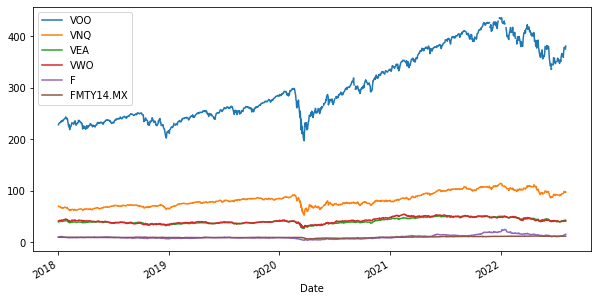

Optimal portfolio: [0.584 0.    0.    0.    0.    0.416]
Expected return, volatility and Sharpe ratio: [0.09898754 0.14754731 0.67088678]


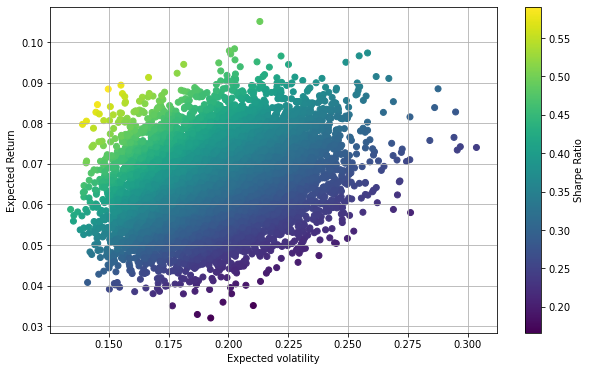

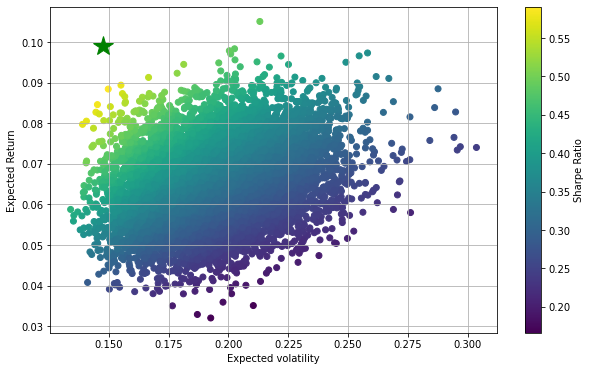

In [76]:
%run download_data.py

In [44]:
!python download_data.py

<Figure size 1000x500 with 1 Axes>
                 VOO  ...  FMTY14.MX
Date                  ...           
2018-01-02       NaN  ...        NaN
2018-01-03  0.005932  ...   0.007905
2018-01-04  0.004376  ...  -0.007905
2018-01-05  0.006389  ...   0.007118
2018-01-08  0.002068  ...   0.000000
...              ...  ...        ...
2022-07-28  0.012561  ...  -0.000834
2022-07-29  0.014546  ...   0.000000
2022-08-01 -0.003014  ...   0.000000
2022-08-02 -0.006482  ...   0.000834
2022-08-03  0.015497  ...   0.000833

[1186 rows x 6 columns]
